# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

Столбцы данных
<pre>
children         — количество детей в семье
days_employed    — общий трудовой стаж в днях
dob_years        — возраст клиента в годах
education        — уровень образования клиента
education_id     — идентификатор уровня образования
family_status    — семейное положение
family_status_id — идентификатор семейного положения
gender           — пол клиента
income_type      — тип занятости
debt             — имел ли задолженность по возврату кредитов
total_income     — ежемесячный доход
purpose          — цель получения кредита
</pre>

## Исследование датасета

In [279]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [280]:
data = pd.read_csv('data.csv')

In [281]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [282]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Итак, у нас есть данные, в которых мы сразу можем увидеть, что некоторые столбцы 

## Предобработка данных

### Удаление пропусков

Смотрим количество пропусков

In [283]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Один из них — `days_employed`. Пропуски в этом столбце обработаю на следующем этапе. Другой столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [284]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В данных встречаются артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. таким артефактом будет отрицательное количество дней трудового стажа в столбце `days_employed`. Заменяю все отрицательные значения положительными.

In [285]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости вывожу медианное значение трудового стажа `days_employed` в днях.

In [286]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставляю их как есть. Тем более этот столбец не понадобится для исследования.

Вывожу перечень уникальных значений столбца `children`.

In [287]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Удаляю строки, в которых встречаются такие аномальные значения из датафрейма `data`.

In [288]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Ещё раз вывожу перечень уникальных значений столбца `children`, чтобы убедиться, что артефакты удалены.

In [289]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполняю пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.

In [290]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Убеждаюсь, что все пропуски заполнены.

In [291]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

Заменяю вещественный тип данных в столбце `total_income` на целочисленный.

In [292]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обрабатываю неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Привожу их к нижнему регистру. Проверяю остальные столбцы.

In [293]:
data['education'] = data['education'].str.lower()

Вывожу на экран количество строк-дубликатов в данных. Если такие строки присутствуют, удаляю.

In [294]:
data.duplicated().sum()

71

In [295]:
data = data.drop_duplicates()

### Категоризация данных

На основании диапазонов, указанных ниже, создаю в датафрейме `data` столбец `total_income_category` с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [296]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [297]:
data['total_income_category'] = data['total_income'].apply(categorize_income)
data['total_income_category']

0        B
1        C
2        C
3        B
4        C
        ..
21520    B
21521    C
21522    C
21523    B
21524    C
Name: total_income_category, Length: 21331, dtype: object

Вывожу на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [298]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создаю функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [299]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [300]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

In [301]:
data['purpose_category']

0        операции с недвижимостью
1          операции с автомобилем
2        операции с недвижимостью
3           получение образования
4              проведение свадьбы
                   ...           
21520    операции с недвижимостью
21521      операции с автомобилем
21522    операции с недвижимостью
21523      операции с автомобилем
21524      операции с автомобилем
Name: purpose_category, Length: 21331, dtype: object

### Исследую данные, чтобы ответить на вопросы

#### 3.1 Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [302]:
gist = pd.DataFrame(data.groupby('children')['debt'].sum())
gist = gist.reset_index()
gist['no_debt'] = data.groupby('children')['debt'].count() - gist['debt']
gist['people'] = data.groupby('children')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist

,children,debt,no_debt,people,debt_percent,no_debt_percent
0,0,1063,13028,14091,0.075438,0.924562
1,1,444,4364,4808,0.092346,0.907654
2,2,194,1858,2052,0.094542,0.905458
3,3,27,303,330,0.081818,0.918182
4,4,4,37,41,0.097561,0.902439
5,5,0,9,9,0.000000,1.000000


In [303]:
data['children_group'] = data['children'].apply(lambda x: 'Нет детей' if x == 0 else 'Дети есть')

df_example = data.groupby('children_group')['debt'].agg(['count', 'sum', 'mean', lambda x: 1 - x.mean()])
df_example.columns = ['Кол-во пользователей', 'Кол-во должников', '% должников', '% НЕдолжников']
df_example.style.format({'% должников': '{:.2%}', '% НЕдолжников': '{:.2%}'})

,Кол-во пользователей,Кол-во должников,% должников,% НЕдолжников
children_group,,,,
Дети есть,7240,669,9.24%,90.76%
Нет детей,14091,1063,7.54%,92.46%


Теперь нужно разобраться с табличными данными: 
<pre>
debt                  - должники  
children              - число детей  
no_debt               - не должники  
people                - всего людей  
debt_percent          - процент должников от всех людей  
no_debt_percent       - процент не должников от всех людей 
</pre>

Теперь нам нужно создать графики последних двух колонок. Если мы будем сравнивать количество людей, то анализ будет неверный - так как семей с пятью детьми куда меньше, чем бездетных.

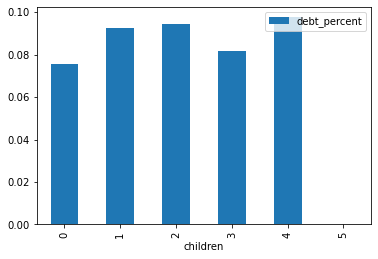

In [304]:
import seaborn as sns
import matplotlib.pyplot as plt
gist.plot(x = 'children', y = 'debt_percent', kind='bar');
#график количество детей/количество должников

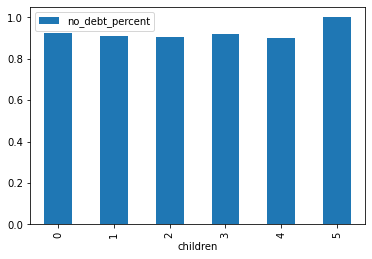

In [305]:
gist.plot(x = 'children', y = 'no_debt_percent', kind='bar');
#график количество детей/количество надёжных заёмщиков

In [306]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = {'index': 'children', 'valid_category': '0', 'flag': flag, 'no_valid_category': '4'}
gist_all = pd.DataFrame(row, index = [0])
gist_all
#в конце

,index,valid_category,flag,no_valid_category
0,children,0,0.097561,4


<pre>
index             - название признака, по которым разбиваются категории  
valid_category    - самая надёжная категория  
flag              - разница между максимальным и минимальным процентом должников, показывает насколько сильно различаются категории и на какие нужно обратить внимание  
no_valid_category - самая ненадёжная категория  
</pre>

Сводная таблица будет в конце.


**Вывод:** 
Исходя из графиков, можно сказать, что больше всего должников имеют двух или четырёх детей.

#### 3.2 Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [307]:
gist =  pd.DataFrame(data.groupby('family_status')['debt'].sum())
gist['no_debt'] = data.groupby('family_status')['debt'].count()- gist['debt']
gist['people'] = data.groupby('family_status')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
gist

,family_status,debt,no_debt,people,debt_percent,no_debt_percent
0,Не женат / не замужем,273,2523,2796,0.097639,0.902361
1,в разводе,84,1105,1189,0.070648,0.929352
2,вдовец / вдова,63,888,951,0.066246,0.933754
3,гражданский брак,385,3749,4134,0.093130,0.906870
4,женат / замужем,927,11334,12261,0.075606,0.924394


In [308]:
table = pd.pivot_table(data, values='debt', index='family_status')
table['% не_должников'] = table['debt'].apply(lambda x: 1-x)
table = table.rename(columns={'debt':'% должников'})
table.style.format({'% не_должников':'{:.2%}', '% должников':'{:.2%}'})

,% должников,% не_должников
family_status,,
Не женат / не замужем,9.76%,90.24%
в разводе,7.06%,92.94%
вдовец / вдова,6.62%,93.38%
гражданский брак,9.31%,90.69%
женат / замужем,7.56%,92.44%


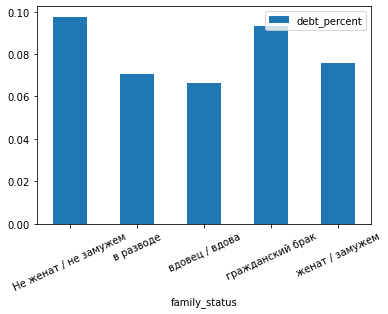

In [309]:
gist.plot(x ='family_status', y ='debt_percent', kind='bar')
plt.xticks(rotation=25);
#график семейное положение/количество должников 

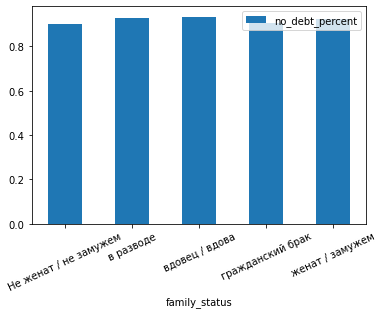

In [310]:
gist.plot(x ='family_status', y ='no_debt_percent', kind='bar')
plt.xticks(rotation=25)
plt.show()
#график семейное положение/количество надёжных заёмщиков

In [311]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'family_status', 'valid_category': 'вдовец/вдова', 'flag': flag, 'no_valid_category': 'Не женат / не замужем'})
gist_all = gist_all.append(row, ignore_index=True)
gist_all
#в конце

,index,valid_category,flag,no_valid_category
0,children,0,0.097561,4
1,family_status,вдовец/вдова,0.031393,Не женат / не замужем


**Вывод:** 
Люди, которые не в браке или в гражданском браке чаще всего являются должниками.

#### 3.3 Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [312]:
gist =  pd.DataFrame(data.groupby('total_income_category')['debt'].sum())
gist['no_debt'] = data.groupby('total_income_category')['debt'].count()- gist['debt']
gist['people'] = data.groupby('total_income_category')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
gist

,total_income_category,debt,no_debt,people,debt_percent,no_debt_percent
0,A,2,23,25,0.080000,0.920000
1,B,354,4660,5014,0.070602,0.929398
2,C,1353,14568,15921,0.084982,0.915018
3,D,21,328,349,0.060172,0.939828
4,E,2,20,22,0.090909,0.909091


Вспомним категории:   
0–30000 — 'E';   
30001–50000 — 'D';   
50001–200000 — 'C';      
200001–1000000 — 'B';   
1000001 и выше — 'A'.   

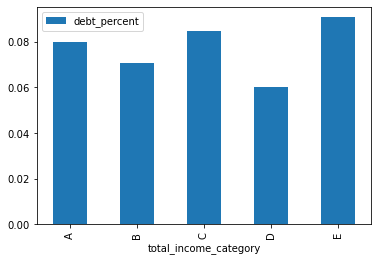

In [313]:
gist.plot(x ='total_income_category', y ='debt_percent', kind='bar');
#график категория зарплат/количество должников

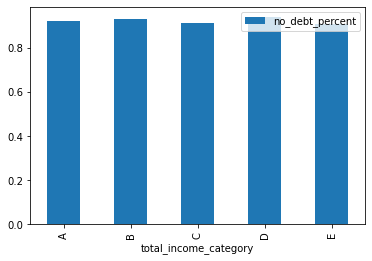

In [314]:
gist.plot(x ='total_income_category', y ='no_debt_percent', kind='bar');
#график категория зарплат/количество надёжных заёмщиков

In [315]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'income','valid_category': '30001–50000', 'flag': flag, 'no_valid_category': '0–30000'})
gist_all = gist_all.append(row, ignore_index=True)
#в конце

**Вывод:** 
Больший процент должников имеет доходную категорию Е (0–30000) и С (50001–200000).

#### 3.4 Как разные цели кредита влияют на его возврат в срок?

In [316]:
gist =  pd.DataFrame(data.groupby('purpose_category')['debt'].sum())
gist['no_debt'] = data.groupby('purpose_category')['debt'].count()- gist['debt']
gist['people'] = data.groupby('purpose_category')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
gist

,purpose_category,debt,no_debt,people,debt_percent,no_debt_percent
0,операции с автомобилем,400,3879,4279,0.093480,0.906520
1,операции с недвижимостью,780,9971,10751,0.072551,0.927449
2,получение образования,369,3619,3988,0.092528,0.907472
3,проведение свадьбы,183,2130,2313,0.079118,0.920882


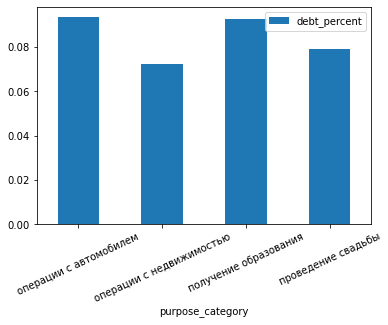

In [317]:
gist.plot(x ='purpose_category', y ='debt_percent', kind='bar')
plt.xticks(rotation=25);
#график цель займа/количество должников

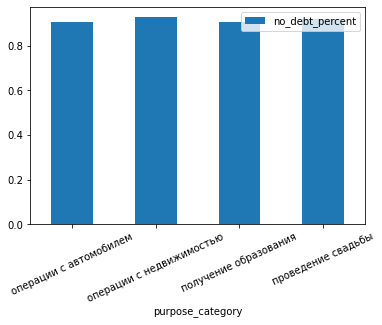

In [318]:
gist.plot(x ='purpose_category', y ='no_debt_percent', kind='bar')
plt.xticks(rotation=25);
#график цель займа/количество надёжных заёмщиков

In [319]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'purpose', 'valid_category': 'недвижимость', 'flag': flag, 'no_valid_category': 'автомобиль'})
gist_all = gist_all.append(row, ignore_index=True)
#в конце

**Вывод:** 
Цели, связанные с автомобилями и образованием, имеют больше просрочек, нежели остальные.

#### 3.5 Приведите возможные причины появления пропусков в исходных данных.

*Ответ:* 
- неправильное заполнение данных во время оформления заявки  
- неправильный перенос данных в таблицу (человеческий фактор)
- не заполнение данных пользователем

#### 3.6 Объясните, почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

*Ответ:* 
Среднее значение неудобно, потому что здесь нужно работать с выбросами и исключать их. Поэтому легче выбрать медиану.

### Шаг 4: общий вывод.

Мы уже выяснили, что наиболее надёжные заёмщики:
- имеют 3, 5 детей или бездетны
- не в браке или в гражданском браке
- имеют D или B категорию зарплаты (200001–1000000, 30001-50000)
- берут кредит с целью операций с недвижимостью или для проведения свадьбы  
Однако мы не проверили возраст, пол, образование и тип занятости. 

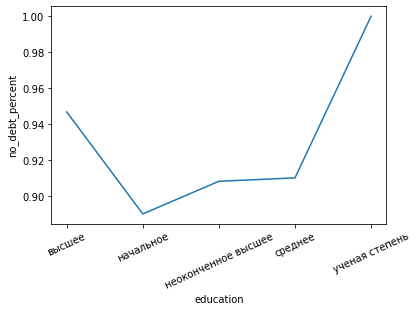

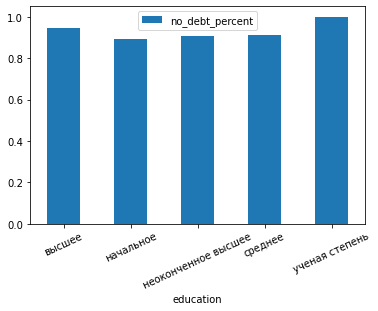

In [320]:
gist =  pd.DataFrame(data.groupby('education')['debt'].sum())
gist['no_debt'] = data.groupby('education')['debt'].count()- gist['debt']
gist['people'] = data.groupby('education')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
sns.lineplot(x = gist['education'], y = gist['no_debt_percent'])
plt.xticks(rotation=25)
gist.plot(x ='education', y ='no_debt_percent', kind='bar')
plt.xticks(rotation=25)
plt.show()
#заёмщики с высшим образованием или учёной степенью надёжнее остальных 


In [321]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'education','valid_category': 'учёная степень', 'flag': flag, 'no_valid_category': 'начальное'})
gist_all = gist_all.append(row, ignore_index=True)
#в конце

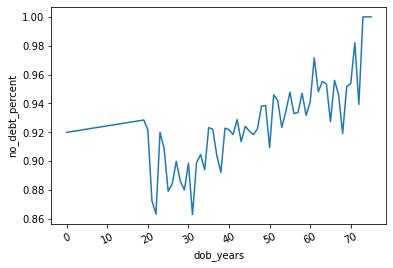

In [322]:
gist =  pd.DataFrame(data.groupby('dob_years')['debt'].sum())
gist['no_debt'] = data.groupby('dob_years')['debt'].count()- gist['debt']
gist['people'] = data.groupby('dob_years')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
sns.lineplot(x = gist['dob_years'], y = gist['no_debt_percent'])
plt.xticks(rotation=25)
plt.show()
#преимущественная тенденция к тому, что с возрастом заёмщик становится более надёжным 
#(так, пик надёжности для 35-летнего заёмщика равен минимуму для 50-летнего)  

In [323]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'dob_years', 'valid_category': '70', 'flag': flag, 'no_valid_category': '20'})
gist_all = gist_all.append(row, ignore_index=True)
#в конце

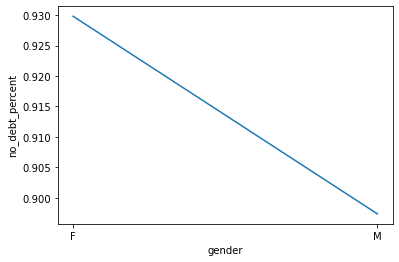

In [324]:
gist =  pd.DataFrame(data.groupby('gender')['debt'].sum())
gist = gist[gist['debt']>0]
gist['no_debt'] = data.groupby('gender')['debt'].count()- gist['debt']
gist['people'] = data.groupby('gender')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
sns.lineplot(x = gist['gender'], y = gist['no_debt_percent'])
plt.show()
#женщины более надёжные заёмщики, чем мужчины

In [325]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'gender', 'valid_category': 'F', 'flag': flag, 'no_valid_category': 'M'})
gist_all = gist_all.append(row, ignore_index=True)
plt.show()
#в конце

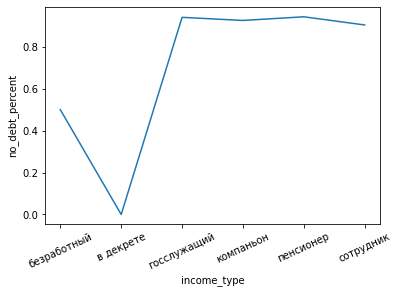

In [326]:
gist =  pd.DataFrame(data.groupby('income_type')['debt'].sum())
gist = gist[gist['debt']>0]
gist['no_debt'] = data.groupby('income_type')['debt'].count()- gist['debt']
gist['people'] = data.groupby('income_type')['debt'].count()
gist['debt_percent'] = gist['debt'] / gist['people']
gist['no_debt_percent'] = gist['no_debt'] / gist['people']
gist = gist.reset_index()
sns.lineplot(x = gist['income_type'], y = gist['no_debt_percent'])
plt.xticks(rotation=25)
plt.show()
#госслужащие и пенсионеры - самые надёжные заёмщики

In [327]:
flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
row = pd.Series(data = {'index': 'income_type', 'valid_category': 'пенсионер', 'flag': flag, 'no_valid_category': 'в декрете'})
gist_all = gist_all.append(row, ignore_index=True)
#в конце

In [328]:
gist_all = gist_all.sort_values('flag', ascending=False).reset_index(drop=True)
gist_all

,index,valid_category,flag,no_valid_category
0,income_type,пенсионер,0.943337,в декрете
1,dob_years,70,0.136937,20
2,education,учёная степень,0.109929,начальное
3,children,0,0.097561,4
4,gender,F,0.032471,M
5,family_status,вдовец/вдова,0.031393,Не женат / не замужем
6,income,30001–50000,0.030737,0–30000
7,purpose,недвижимость,0.020928,автомобиль


<pre>
index             - название признака, по которым разбиваются категории  
valid_category    - самая надёжная категория  
flag              - разница между максимальным и минимальным процентом должников, показывает насколько сильно различаются категории и на какие нужно обратить внимание  
no_valid_category - самая ненадёжная категория 
</pre>

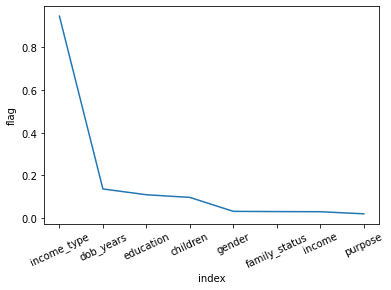

In [329]:
sns.lineplot(x = gist_all['index'], y = gist_all['flag'])
plt.xticks(rotation=25);

# **Выводы**   
По таблице можно найти самых надёжных заёмщиков: в основном, это пенсионеры. Также можно увидеть те категории, которые сильно различаются коэффициентом значимости. Например, разные цели покупки не так сильно влияют на возвращение займа, нежели род деятельности. При более детальном рассмотрении этого вопроса можно создать сводную таблицу, в которой:
- коэффициент значимости категории будет переведён в формат 100%
- коэффициент будет просчитан для каждой категории и каждая категория будет отсортирована по порядку

Также можно создать функции, которые будут автоматически высчитывать коэффициент или строить графики. Пример функций ниже.
(решил в этом проекте их не использовать, чтобы отработать встроенные функции библиотеки)

In [333]:
def grafic(data, category, debt_gist='no_debt_percent', return_data = False, angel=0):
    gist =  pd.DataFrame(data.groupby(category)['debt'].sum())
    gist['no_debt'] = data.groupby(category)['debt'].count()- gist['debt']
    gist['people'] = data.groupby(category)['debt'].count()
    gist['debt_percent'] = gist['debt'] / gist['people']
    gist['no_debt_percent'] = gist['no_debt'] / gist['people']
    gist = gist.reset_index()
    plot = sns.lineplot(x = gist[category], y = gist[debt_gist])
    plt.xticks(rotation=angel)
    if return_data == False:
        return plot
    else:
        return plot, gist

<pre>
data         - датафрейм  
category     - категория, которую нужно проверить  
debt_gist    - 'no_debt_percent', если график надёжных заёмщиков,  
               'debt_percent', если график ненадёжных заёмщиков   
return_gist  - False, если не возращать датафрейм, на основе которого строится график
               True, если возвращать датафрейм, на основе которого строится график
</pre>

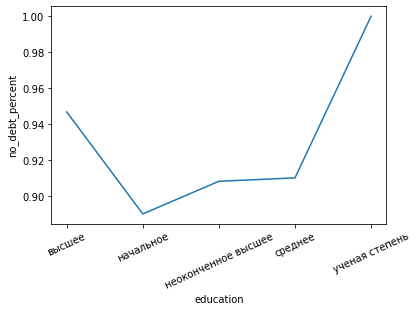

In [334]:
grafic(data, 'education', angel = 25);

In [335]:
def flag_data(gist,
            gist_all = [],
            no_max = False, 
            value = min(gist['no_debt_percent']), 
            create_data = False, 
            index = gist.columns[0], 
            valid_category = gist[gist['no_debt_percent'] == max(gist['no_debt_percent'])][gist.columns[0]].reset_index(drop=True)[0],
            no_valid_category = gist[gist['no_debt_percent'] == min(gist['no_debt_percent'])][gist.columns[0]].reset_index(drop=True)[0]):
    if no_max == False:
        flag = max(gist['no_debt_percent'])-min(gist['no_debt_percent'])
    else:
        flag = max(gist['no_debt_percent'])-value
    if create_data == False:
        row = pd.Series(data = {'index': gist.columns[0], 
                                'valid_category': valid_category, 
                                'flag': flag, 
                                'no_valid_category': no_valid_category})
        gist_all = gist_all.append(row, ignore_index=True)
    else:
        row = {'index': gist.columns[0], 
               'valid_category': valid_category, 
               'flag': flag, 
               'no_valid_category': no_valid_category}
        gist_all = pd.DataFrame(row, index = [0])
    return gist_all

<pre>
gist                 - датафрейм, который использовался для построения гистограмы  
  
gist_all=[]          - датафрейм, который будет сводить в себе все другиедатафреймы для гистограм, вставляется, если он есть  
  
no_max               = False, когда нужно использовать максимально надёжную категорию  
                     = True, когда нужно использовать свою категорию  
  
value                = min(gist['no_debt_percent']) по умолчанию минимальная  
                     = то значение gist['no_debt_percent'], для которого нужно вычислить коэффициент значимости  
  
create_data          = False, если у пользователя уже есть gist_all  
                     = True, если нужно создавать датафрейм, который в последствии будет общей сводной таблицей  
  
index                = gist.columns[0], если название столбец с категориями первый   
                     = любое другое название столбца с категориями в новом датафрейме  
  
valid_category       = gist[gist['no_debt_percent'] == max(gist['no_debt_percent'])][gist.columns[0]].reset_index(drop=True)[0], валидная категория, которая имеет максимальную надёжность  
                     = категория пользователя  
  
no_valid_category    = gist[gist['no_debt_percent'] == min(gist['no_debt_percent'])][gist.columns[0]].reset_index(drop=True)[0], минимально валидная категория  
                     = категория пользователя
</pre>

In [336]:
gist_all_2 = flag_data(gist, create_data = True)
gist_all_2

,index,valid_category,flag,no_valid_category
0,income_type,пенсионер,0.943337,в декрете
